In [129]:
# Load dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pymongo import MongoClient
from pprint import pprint

In [130]:
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Category20c
from math import pi
import plotly.express as px

Import data:
mongoimport --type csv -d SpotifyDataset -c SpotifySongs --headerline --drop project_3_clean.csv

In [131]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [132]:
# confirm database was created
print(mongo.list_database_names())

['SpotifyDataset', 'admin', 'config', 'spotify', 'spotifyData', 'spotifyTest']


In [133]:
# assign the database to a variable name
spotify_db = mongo['SpotifyDataset']

In [134]:
# review the collections in our new database
print(spotify_db.list_collection_names())

['SpotifySongs']


In [135]:
# review a document collection
print(spotify_db.SpotifySongs.find_one())

{'_id': ObjectId('6711b921c1425e20be8accee'), 'artist': 'blink-182', 'song': 'all the small things', 'duration_ms': 167066, 'explicit': 'False', 'year': 1999, 'popularity': 79, 'danceability': 44.51282051282051, 'energy': 89.7897897897898, 'key': 0, 'loudness': -4.918, 'mode': 1, 'speechiness': 8.472222222222223, 'acousticness': 1.1534154535274355, 'instrumentalness': 0.0, 'liveness': 71.74677608440797, 'valence': 70.29804727646454, 'tempo': 148.726, 'genre': 'rock', 'duration_minutes': 2.7844333333333333}


In [136]:
# assign the collection to a variable
songs = spotify_db['SpotifySongs']

In [137]:
# Display the number of documents 
songs.count_documents({})

1838

Kimberly's Code: Top 10 Artists by Song Count & Top Artist's Song Popularity Percentages

In [138]:
#Aggregate by artist
artists = [
    { 
        "$group": {
            "_id": "$artist",  # Group by the artist field
            "count": {"$sum": 1}  # Count the number of occurrences of each artist
        }
    },
    { 
        "$sort": {"count": -1}  # Sort by count in descending order
    },
    { 
        "$limit": 10  # Limit the result to the top artist
    }
]
results = list(songs.aggregate(artists))

In [139]:
# Output the top 10 artists with their counts
print("Top 10 artists:")
top_artists = []
for i, artist in enumerate(results, start=1):
    print(f"{i}. {artist['_id']} with {artist['count']} songs.")
    top_artists.append(artist['_id'])  # Store top artist names

Top 10 artists:
1. rihanna with 22 songs.
2. eminem with 21 songs.
3. calvin harris with 20 songs.
4. drake with 19 songs.
5. britney spears with 18 songs.
6. david guetta with 18 songs.
7. taylor swift with 16 songs.
8. katy perry with 16 songs.
9. chris brown with 16 songs.
10. kanye west with 16 songs.


In [140]:
# Extract data for plotting
artist_names = [artist['_id'] for artist in results]
song_counts = [artist['count'] for artist in results]

In [241]:
# Create a DataFrame for the data
data = {
    'Artists': artist_names,
    'Number of Songs': song_counts
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create the bar plot using Plotly Express
fig = px.bar(df, x= 'Artists', y= 'Number of Songs', 
             title='Top 10 Artists by Number of Songs',
             labels={'Artists': 'Artists', 'Number of Songs': 'Number of Songs'},
             color='Number of Songs',  # Color by the number of songs
             color_continuous_scale=px.colors.sequential.Greens)  # Color scale

# Show the plot
fig.update_layout(xaxis_tickangle=0)  
fig.show()

In [142]:
#Aggregate by popularity
artist_popularity = [
    { 
        "$group": {
            "_id": "$artist",  # Group by the artist field
            "count": { "$sum": 1 },  # Count the number of occurrences of each artist
            "total_popularity": { "$sum": "$popularity" },  # Sum the popularity score for each artist
            "average_popularity": { "$avg": "$popularity" }  # Calculate the average popularity percentage
        }
    },
    { 
        "$sort": { "count": -1 }  # Sort by count in descending order
    },
    { 
        "$limit": 10  # Limit the result to the top 10 artists
    }
]

# Run the aggregation query
popularity_results = list(songs.aggregate(artist_popularity))

In [143]:
# Output the top 10 artists with their counts and average popularity percentage
print("Top 10 artists with average popularity percentage:")
for i, artist in enumerate(popularity_results, start=1):
    print(f"{i}. {artist['_id']}: {artist['count']} songs - Average Popularity: {artist['average_popularity']:.2f}%")

Top 10 artists with average popularity percentage:
1. rihanna: 22 songs - Average Popularity: 72.09%
2. eminem: 21 songs - Average Popularity: 72.33%
3. calvin harris: 20 songs - Average Popularity: 67.80%
4. drake: 19 songs - Average Popularity: 63.79%
5. david guetta: 18 songs - Average Popularity: 65.83%
6. britney spears: 18 songs - Average Popularity: 63.06%
7. kanye west: 16 songs - Average Popularity: 61.44%
8. taylor swift: 16 songs - Average Popularity: 70.31%
9. chris brown: 16 songs - Average Popularity: 63.25%
10. katy perry: 16 songs - Average Popularity: 64.56%


Dylan's Code: Comparing Danceability vs. Energy of the Top Artist's Songs

In [144]:
# Define the fields for the x and y axes
x_field = 'danceability' 
y_field = 'energy'  

In [145]:
# Fetch data from the songs collection
data = list(songs.find({}, {x_field: 1, y_field: 1}))

In [146]:
# Extract x and y values
x_values = [item[x_field] for item in data]
y_values = [item[y_field] for item in data]

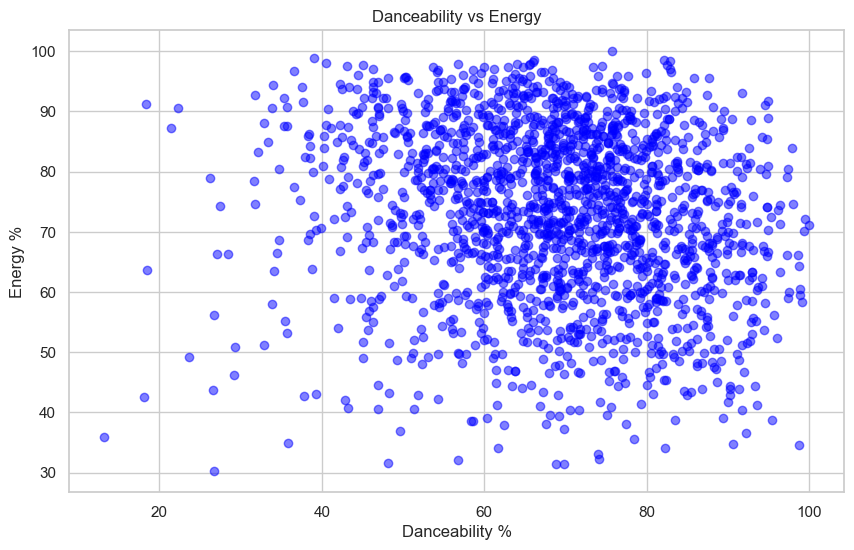

In [147]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.5)
plt.title('Danceability vs Energy')
plt.xlabel('Danceability %')
plt.ylabel('Energy %')
plt.grid(True)

# Show the plot
plt.show()

In [148]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [149]:
#Aggregate genre counts
genre_counts = list(songs.aggregate([
    {"$group": {"_id": "$genre", "count": {"$sum": 1}}},  # Group by genre and count
    {"$project": {"genre": "$_id", "count": 1}}  # Reshape the output
]))

In [150]:
#Convert DF 
genre_counts_df = pd.DataFrame(genre_counts)

In [151]:
#Prepare data for Bokeh
genre_counts_df['angle'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 2 * pi
genre_counts_df['color'] = Category20c[len(genre_counts_df)]

In [152]:
#Create the wedge plot
output_notebook()  
p = figure(outer_height=350, title="Song Genres Distribution", toolbar_location=None,
           tools="hover", tooltips="@genre: @count", x_range=(-0.5, 1.0))
p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True),
         end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='genre', 
         source=genre_counts_df)

# Add the circle
p.circle(x=0, y=1, radius=0.2, color="white")

# Adjust axis and grid visibility
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

# Show the plot
show(p)

Loading BokehJS ...

Adolphus' Code: Song Popularity Trends by Year and 

In [153]:
# Step 1: Aggregate popularity trends by year and genre
popularity_trends = list(songs.aggregate([
    {
        "$group": {
            "_id": {
                "year": "$year",  # Group by the existing 'year' field
                "genre": "$genre"  # Group by genre
            },
            "average_popularity": {"$avg": "$popularity"}  # Calculate average popularity
        }
    },
    {
        "$project": {
            "year": "$_id.year",
            "genre": "$_id.genre",
            "average_popularity": 1
        }
    },
    {
        "$sort": {
            "year": 1,  # Sort by year
            "genre": 1   # Sort by genre
        }
    }
]))

In [154]:
# Step 2: Convert the aggregation results to a DataFrame
popularity_trends_df = pd.DataFrame(popularity_trends)
# Display the DataFrame
print(popularity_trends_df.head())

                                           _id  average_popularity  year  \
0  {'year': 1999, 'genre': 'Dance/Electronic'}           56.000000  1999   
1           {'year': 1999, 'genre': 'hip hop'}           69.666667  1999   
2               {'year': 1999, 'genre': 'pop'}           62.173913  1999   
3              {'year': 1999, 'genre': 'rock'}           70.166667  1999   
4     {'year': 2000, 'genre': 'Folk/Acoustic'}            0.000000  2000   

              genre  
0  Dance/Electronic  
1           hip hop  
2               pop  
3              rock  
4     Folk/Acoustic  


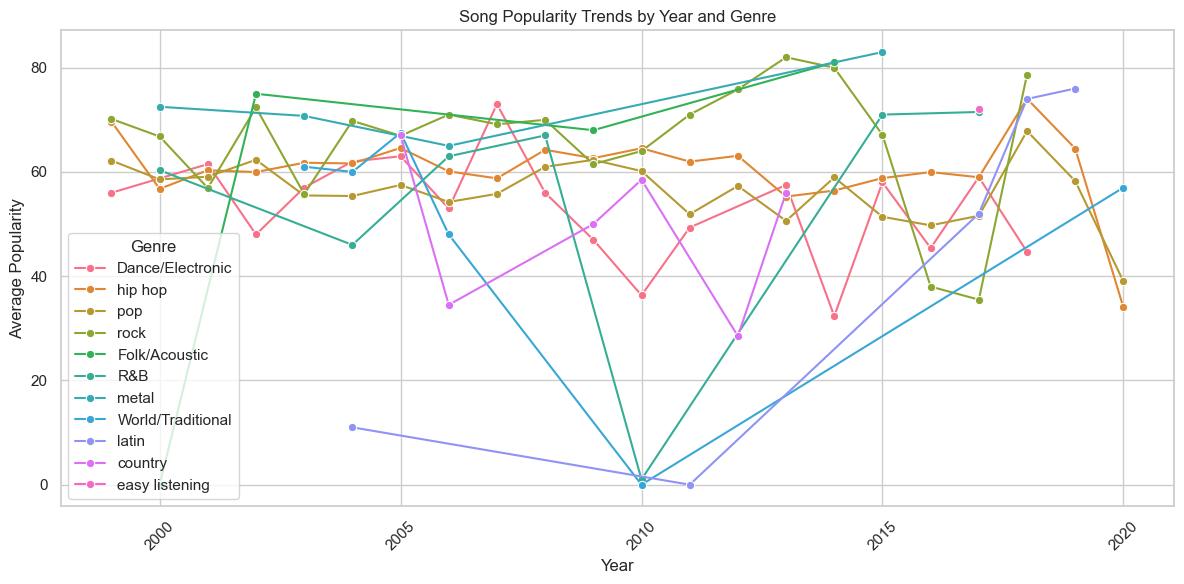

In [155]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
# reate a line plot for popularity trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=popularity_trends_df, x='year', y='average_popularity', hue='genre', marker='o')
plt.title('Song Popularity Trends by Year and Genre')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.legend(title='Genre')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Sanjana's Code:

In [201]:
# convert popularity to numeric values
update_result = songs.update_many(
    {"popularity": {"$type": "string"}},
    [
        {
            "$set": {
                "popularity": {
                    "$toDouble": {
                        "$substr": ["$popularity", 0, {"$subtract": [{"$strLenCP": "$popularity"}, 1]}]
                    }
                }
            }
        }
    ]
)

In [202]:
# Count the total number of songs
total_songs = songs.count_documents({})

# Calculate the index positions for the 90th and 10th percentiles
top_10_index = int(0.9 * total_songs)
bottom_10_index = int(0.1 * total_songs)

In [203]:
# Get the popularity score at the 90th and 10th percentiles
# Find the song at the top 10% index (90th percentile)
top_10_percentile_song = list(songs.find({}, {"popularity": 1}).sort("popularity", -1).skip(top_10_index).limit(1))

# Find the song at the bottom 10% index (10th percentile)
bottom_10_percentile_song = list(songs.find({}, {"popularity": 1}).sort("popularity", 1).skip(bottom_10_index).limit(1))

In [208]:
# Check if we got results and extract the popularity values
if top_10_percentile_song and bottom_10_percentile_song:
    top_10_percent = top_10_percentile_song[0]["popularity"]
    bottom_10_percent = bottom_10_percentile_song[0]["popularity"]

    
    # Query to get the top 10% of songs by popularity and sort in descending order
    top_songs = list(songs.find({"popularity": {"$gte": top_10_percent}}).sort("popularity", -1))

    # Query to get the bottom 10% of songs by popularity and sort in ascending order
    bottom_songs = list(songs.find({"popularity": {"$lte": bottom_10_percent}}).sort("popularity", -1))


    # Output the top and bottom songs
    print("Top 10% of songs by popularity (ordered by popularity descending):")
    for i, song in enumerate(top_songs, start=1):
        print(f"{i}. {song['song']} - Popularity: {song['popularity']}%")
    
    print("\nBottom 10% of songs by popularity (ordered by popularity descending):")
    for i, song in enumerate(bottom_songs, start=1):
        print(f"{i}. {song['song']} - Popularity: {song['popularity']}%")

Top 10% of songs by popularity (ordered by popularity descending):
1. sweater weather - Popularity: 89%
2. another love - Popularity: 88%
3. without me - Popularity: 87%
4. the real slim shady - Popularity: 86%
5. wait a minute! - Popularity: 86%
6. 'till i collapse - Popularity: 85%
7. locked out of heaven - Popularity: 85%
8. daddy issues - Popularity: 85%
9. the nights - Popularity: 85%
10. perfect - Popularity: 85%
11. circles - Popularity: 85%
12. why'd you only call me when you're high? - Popularity: 84%
13. do i wanna know? - Popularity: 84%
14. the hills - Popularity: 84%
15. one dance - Popularity: 84%
16. shape of you - Popularity: 84%
17. no lie - Popularity: 84%
18. lucid dreams - Popularity: 84%
19. someone you loved - Popularity: 84%
20. in the end - Popularity: 83%
21. stan - Popularity: 83%
22. get lucky (feat. pharrell williams & nile rodgers) - radio edit - Popularity: 83%
23. night changes - Popularity: 83%
24. stressed out - Popularity: 83%
25. the less i know the b

In [223]:
# Query to get the top 10% of songs by popularity and sort in descending order
top_songs = list(songs.find(
    {"popularity": {"$gte": top_10_percent}},
    {"song": 1, "loudness": 1, "valence": 1, "popularity": 1}  # Select only necessary fields
).sort("popularity", -1))
# Convert to DataFrame
top_songs_df = pd.DataFrame(top_songs)


- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [225]:
# Plot for Top 10% songs
fig_top = px.scatter(top_songs_df, x='loudness', y='valence', 
                     color='popularity', 
                     title="Top 10% Most Popular Songs: Loudness vs Valence",
                     labels={'loudness':'Loudness (Decibles)', 'valence':'Valence (Positivity)'},
                     hover_name='song',  # Use the correct field name for song title
                     size='popularity',
                     color_continuous_scale=px.colors.sequential.Peach,
                     template='plotly_dark')

# Show the plot
fig_top.show()